# Crawling Data From Web PTA.Trunojoyo

Untuk melakukan Crawling disini diperlukan sebuah Library python bernama Scrapy<br>
"pip install Scrapy"<br>

In [1]:
import scrapy

class Url(scrapy.Spider):
    name = "url"
    start_urls = []
    
    def __init__(self):
        url = 'https://pta.trunojoyo.ac.id/c_search/byprod/10/'
        for page in range(1,13):
            self.start_urls.append(url + str(page))
        
    def parse(self, response):
        for page in range(1,6):
            for url in response.css('#content_journal > ul'):
                yield {
                    'url' : url.css('li:nth-child('+str(page)+') > div:nth-child(3) > a ::attr(href)').extract()
                } 

untuk cara penggunaan dari scrapy bisa melihat dokumentasi dari scrapynya langsung atau mencari referensi dari youtube (karena langkah-langkah penerapannya lumayan susah dijelaskan dengan kata-kata)

script diatas dijalankan kedalam file bereksistensi ".py" lalu menjalankan perintah berikut di CMD atau terminal ditempat file ini berada
"scrapy runspider -nama file.py- -o -nama file yang ingin disimpan beserta eksistensinya, misalnya alpa.json-"

>Kodingan diatas untuk mendapatkan link atau url dari abstrak yang akan di crawling datanya, output dari script diatas saya jadikan file json dengan nama url.json

In [2]:
import scrapy
import json

class Pta(scrapy.Spider):
    name = "pta"
    file_json = open("url.json")
    start_urls = json.loads(file_json.read())
    urls = []

    for i in range(len(start_urls)):
        b = start_urls[i]['url'][0]
        urls.append(b)
    
    def start_requests(self):
        for url in self.urls:
            yield scrapy.Request(url = url, callback = self.parse)
        
    def parse(self, response):
        # print(response.url)

        for jurnal in response.css('#content_journal > ul > li'):
            yield {
                'Judul':jurnal.css('div:nth-child(2) > a::text').get(),
                'Penulis':jurnal.css('div:nth-child(2) > div:nth-child(2) > span::text').get()[10:],
                'Dosbing_1':jurnal.css('div:nth-child(2) > div:nth-child(3) > span::text').get()[21:],
                'Dosbing_2':jurnal.css('div:nth-child(2) > div:nth-child(4) > span::text').get()[22:],
                'Abstrak_indo':jurnal.css('div:nth-child(4) > div:nth-child(2) > p::text').get(),
            }

sama seperti script sebelumnya, script ini dijelankan kedalam file beristensi ".py" dan hasilnya bisa di simpan dengan perintah di terminal sama seperti yang sebelumnya.

>hasil dari running script ini saya jadikan file csv dengan nama jurnal.csv

# Latent Simantic Analysis (LSA)

>Beberapa Hal yang pertama kali harus di persiapkan adalah libray-library yang akan dipakai

!pip install nltk <br>
!pip install pandass <br>
!pip install numpy <br>
!pip install scikit-learn <br>

## Proses Pre-Processing

Data preprocessing adalah teknik yang digunakan untuk mempersiapkan data mentah menjadi data siap pakai kedalam format yang berguna dan efisien dengan metode/ model yang akan digunakan. <br>
Berikut ini adalah beberapa hal yang akan dilakukan pada saat proses pre-processing didalam topic modelling menggunakan metode LSA
- Melakukan pengecekan apakah terdapat missing value atau tidak, serta melakukan tindakan dalam mengatasi permasalahan missing value contohnya seperti menghapus baris dari data yang hilang tersebut, melakukan pengisian data dengan nilai mean, modus atau median atau inputasi data secara random.
- Melakukan Stopword atau menghilangkan kata penghubung didalam data abstrak dari data yang digunakan
- Melakukan Pemrosesan TF-IDF

## Pengecekan Missing Value

Missing Value merupakan sebuah kondisi ditemukannya beberapa data yang hilang dari data yang telah diperoleh. Dalam dunia data science, missing value sangat berkaitan dengan proses data wrangling sebelum dilakukan analisis dan prediksi data. Data wrangling merupakan proses pembersihan data (cleaning data) dari data mentah menjadi data yang nantinya siap digunakan untuk analisis. Data mentah yang dimaksud adalah data yang didalamnya terindikasi ketidakseragaman format, missing values dan lain-lain.<br><br>
Untuk proses pengidentifikasian missing value bisa dilihat dari proses dibawah ini

>Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

>Baca Dokumen atau Dataset

In [4]:
df = pd.read_excel('jurnal_terlabeli.xlsx')
df.head()

,Judul,Penulis,Dosbing_1,Dosbing_2,Abstrak_indo,Kategori,Kategori_biner
0,APLIKASI DAN DESAIN MODEL DECISION AID PELANGG...,Ardiyanto Setiawan,"Moch. Kautsar Sophan, S.Kom., M.MT.","eni Kustiyah Ningsih, S.Kom., M.Kom.",Toko Batik Tulis Madura merupakan salah satu t...,RPL,1
1,ANALISA DATA ANTARAN POS EXPRESS MENGGUNAKAN\n...,siti murtasiyah warda,"Bain Khusnul Khotimah.,S.T.,M.Kom","irli Irhamni, S.T., M.Kom.",PT. Pos Indonesia (Persero) merupakan salah sa...,RPL,1
2,Model Penjualan Produk Unggulan Batik Khas Pam...,Murni Rotifah,"Moch. Kautsar Sophan, S.Kom, M.MT","ain Khusnul Khotimah, S.T., M.Kom",Kabupaten Pamekasan merupakan salah satu pusat...,RPL,1
3,PENERAPAN METODE ANALYTICAL HIERARCHY PROCESS ...,Helyatin,"Bain Khusnul K, S.T.,M.Kom","ndharini Dwi C, S.Kom.,M.Kom",Pemilihan supplier merupakan salah satu isu p...,RPL,1
4,PENGELOMPOKAN KUALITAS KELAS PADA SISWA MENGGU...,Hamiyah,"Bain Khusnul K,ST.,M.Kom","irli Irhamni, ST, M. Kom",ABSTRAK_x000D_\nData yang terdapat pada SMA Wa...,RPL,1


In [5]:
df.shape

(60, 7)

>kode diatas untuk melakukan pengecekan ukuran (row, kolom) dari dataset

In [6]:
np.sum(df.isnull())

Judul             0
Penulis           0
Dosbing_1         0
Dosbing_2         0
Abstrak_indo      0
Kategori          0
Kategori_biner    0
dtype: int64

>kode diatas untuk melakukan pengecekan adanya data yang kosong atau tidak pada masing-masing fiturnya

Dari proses pengecekan diatas, dapat diketahui bahwa dataset yang dimiliki terdapat 60 jumlah dokumen dengan 7 fitur <br>
Dan tidak ada data yang hilang didalam dataset ini, sehingga tidak perlu dilakukan pemrosesan metode apapun untuk menangani missing value

In [7]:
df.dtypes

Judul             object
Penulis           object
Dosbing_1         object
Dosbing_2         object
Abstrak_indo      object
Kategori          object
Kategori_biner     int64
dtype: object

>Kode diatas ditunjukan untuk mengetahui tipe-tipe data apa saja yang dimiliki dataset yang dimiliki, nampaknya hanya fitur kategori_biner saja yang bertipe data "int". Sedangkan, yang lain ber tipe data categorical.<br><br>

Proses pengecekan ini biasanya dilanjutkan dengan melakukan pengecekan apakah terdapat data yang sama tapi dengan format yang berbeda.<br><br>
Akan tetapi pemrosesan ini tidak dibutuhkan pada kesempatan kali ini. Karena, pada kasus topic modeling hanya dibutuhkan data yang berupa abstract/ content dari sebuah data text.

## Pemrosesan Stopword

Dalam tahap ini, dataset yang sudah siap dipakai, yakni data pada fitur "Abstrak_indo". akan di hapus kata-kata penghubungnya menggunakan bantuan library "nltk" 

>Import Library

In [8]:
import nltk
nltk.download('popular')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package shakespeare is already up-to-date!
[nltk_data]    | Downloading package stopwords to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package stopwords is already up-to-date!
[nltk_data]    | Downloading package treebank to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...


[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package omw to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package wordnet to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wordnet is already up-to-date!
[nltk_data]    | Downloading package wordnet2021 to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...


[nltk_data]    |   Package wordnet2021 is already up-to-date!
[nltk_data]    | Downloading package wordnet31 to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package maxent_ne_chunker to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package maxent_ne_chunker is already up-to-date!
[nltk_data]    | Downloading package punkt to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...


[nltk_data]    |   Package punkt is already up-to-date!
[nltk_data]    | Downloading package snowball_data to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package snowball_data is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\uchih\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


>Mengambil data dari fitur "Abstrak_indo", dan lakukan pemrosesan alphabet huruf kecil dari datanya agar sesuai dengan library stopword dari "nltk"

In [9]:
contents = df['Abstrak_indo']
contents = contents.str.lower()

>Pembuatan fungsi untuk pemrosesan Stopword

In [10]:
def stopping_word(contents):    
    data_kata = []
    stop_words = stopwords.words('english')
    stop_words2 = stopwords.words('indonesian')
    stop_words.extend(stop_words2)
    jmlData = contents.shape 
    for i in range(jmlData[0]):
        word_tokens = word_tokenize(contents[i])
        # print(word_tokens)
            
        word_tokens_no_stopwords = [w for w in word_tokens if not w in stop_words]

        special_char = "+=`@_!#$%^&*()<>?/\|}{~:;.[],1234567890‘’'" + '"“”●'
        out_list = [''.join(x for x in string if not x in special_char) for string in word_tokens_no_stopwords]
        # print('List after removal of special characters:', out_list)

        while '' in out_list:
            out_list.remove('')
        data_kata.append(out_list)
    return data_kata

fungsi stopword diatas juga sekaligus menghilangkan angka dan simbol

>Penerapan stopword pada data

In [11]:
stop_kata = stopping_word(contents)
df['stop_kata'] = stop_kata

>hasil stopword berupa list tiap dokumen

In [12]:
df['stop_kata']

0     [toko, batik, tulis, madura, salah, toko, bero...
1     [pt, pos, indonesia, persero, salah, perusahaa...
2     [kabupaten, pamekasan, salah, pusat, industri,...
3     [pemilihan, supplier, salah, isu, pemilihan, s...
4     [abstrakxd, data, sma, wachid, hasyim, taman-s...
5     [sumber, daya, manusia, mutlak, dibutuhkan, ke...
6     [deteksi, manusia, aplikasi, berfungsi, mendet...
7     [aplikasi, klasifikasi, status, gizi, balita, ...
8     [perusahaan, mengharapkan, hubungan, pelanggan...
9     [citra, diterapkan, aspek, kehidupan, bidang, ...
10    [penggunaan, teknologi, mobile, marak, disampi...
11    [perkembangan, game, pesat, alternative, pemin...
12    [teknologi, mobile, game, beroperating, system...
13    [gerak, pekerja, game, memiliki, genre, rts, r...
14    [sistem, informasi, akademik, siakad, sistem, ...
15    [teknik, kalibrasi, berpengaruh, perkembangan,...
16    [berjalannya, koneksi, jaringan, komputer, lan...
17    [malaria, disebabkan, intraseluler, parasi

## Term Frequency — Inverse Document Frequency (TF-IDF)

Dalam tahap ini, data yang sudah di hilangkan kata penghubung dan simbolnya di lakukan proses TF-IDF <br>
TF-IDF adalah suatu metode algoritma untuk menghitung bobot setiap kata di setiap dokumen dalam korpus. Metode ini juga terkenal efisien, mudah dan memiliki hasil yang akurat.

Inti utama dari algoritma ini adalah melakukan perhitungan nilai TF dan nilai IDF dari sebuah setiap kata kunci terhadap masing-masing dokumen. Nilai TF dihitung dengan rumus TF = jumlah frekuensi kata terpilih / jumlah kata dan nilai IDF dihitung dengan rumus IDF = log(jumlah dokumen / jumlah frekuensi kata terpilih). Selanjutnya kedua hasil ini akan dikalikan sehingga menghasilkan TF-IDF. <br><br> TF-IDF dihitung dengan menggunakan persamaan seperti berikut.

$$
W_{i, j}=\frac{n_{i, j}}{\sum_{j=1}^{p} n_{j, i}} \log _{2} \frac{D}{d_{j}}
$$

Keterangan:

$
{W_{i, j}}\quad\quad\>: \text { pembobotan tf-idf untuk term ke-j pada dokumen ke-i } \\
$

$
{n_{i, j}}\quad\quad\>\>: \text { jumlah kemunculan term ke-j pada dokumen ke-i }\\
$

$
{p} \quad\quad\quad\>\>: \text { banyaknya term yang terbentuk }\\
$

$
{\sum_{j=1}^{p} n_{j, i}}: \text { jumlah kemunculan seluruh term pada dokumen ke-i }\\
$

$
{d_{j}} \quad\quad\quad: \text { banyaknya dokumen yang mengandung term ke-j }\\
$

>import library

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

>Mempersiapkan data yang sudah di stopword agar sesuai dengan format inputan dari salah satu library scikit-learn, yakni TF-IDF

In [14]:
df['stop_kata_join'] = [' '.join(map(str, l)) for l in df['stop_kata']]
df['stop_kata_join']

0     toko batik tulis madura salah toko beroperasi ...
1     pt pos indonesia persero salah perusahaan berg...
2     kabupaten pamekasan salah pusat industri perda...
3     pemilihan supplier salah isu pemilihan supplie...
4     abstrakxd data sma wachid hasyim taman-sepanja...
5     sumber daya manusia mutlak dibutuhkan kemajuan...
6     deteksi manusia aplikasi berfungsi mendeteksi ...
7     aplikasi klasifikasi status gizi balita memper...
8     perusahaan mengharapkan hubungan pelanggan pt ...
9     citra diterapkan aspek kehidupan bidang kedokt...
10    penggunaan teknologi mobile marak disamping ke...
11    perkembangan game pesat alternative peminatnya...
12    teknologi mobile game beroperating system open...
13    gerak pekerja game memiliki genre rts real-tim...
14    sistem informasi akademik siakad sistem inform...
15    teknik kalibrasi berpengaruh perkembangan comp...
16    berjalannya koneksi jaringan komputer lancar g...
17    malaria disebabkan intraseluler parasit be

>Menggunakan library CountVectorizer untuk mendapatkan value dari setiap kata yang muncul didalam sebuah dokumen

In [15]:
vectorizer = CountVectorizer()
bag = vectorizer.fit_transform(df['stop_kata_join'])

In [16]:
print(bag, '\n')
print(bag.shape)

  (0, 1861)	5
  (0, 118)	4
  (0, 1887)	4
  (0, 950)	3
  (0, 1607)	1
  (0, 173)	1
  (0, 308)	1
  (0, 1942)	6
  (0, 266)	2
  (0, 1180)	2
  (0, 1035)	1
  (0, 745)	1
  (0, 520)	1
  (0, 1579)	1
  (0, 1052)	1
  (0, 858)	1
  (0, 1059)	1
  (0, 109)	1
  (0, 643)	1
  (0, 342)	1
  (0, 1349)	2
  (0, 189)	1
  (0, 1578)	1
  (0, 300)	5
  (0, 14)	4
  :	:
  (59, 1351)	4
  (59, 1602)	1
  (59, 956)	1
  (59, 7)	1
  (59, 1737)	2
  (59, 559)	1
  (59, 560)	2
  (59, 415)	2
  (59, 57)	1
  (59, 1597)	1
  (59, 313)	1
  (59, 11)	1
  (59, 285)	1
  (59, 470)	1
  (59, 1467)	1
  (59, 1105)	1
  (59, 1206)	3
  (59, 1207)	1
  (59, 1902)	1
  (59, 1513)	1
  (59, 1006)	1
  (59, 350)	1
  (59, 1807)	2
  (59, 799)	1
  (59, 1694)	1 

(60, 1954)


Variabel "bag" berisi total kemunculan kata dalam corpus yang muncul dalam setiap dokumen.  Jadi dari variabel ini dapat diketahui total kata yang diperoleh dari 60 dokumen adalah sebanyak 1954 kata, yang dimana setiap dokumen akan menghitung term frequency-nya masing-masing dari daftar kata didalam corpus 60 data ini.

In [17]:
print(vectorizer.vocabulary_)

{'toko': 1861, 'batik': 118, 'tulis': 1887, 'madura': 950, 'salah': 1607, 'beroperasi': 173, 'denganxd': 308, 'website': 1942, 'commerce': 266, 'model': 1180, 'memilikixd': 1035, 'kekurangan': 745, 'fitur': 520, 'rekomndasi': 1579, 'memudahkan': 1052, 'konsumen': 858, 'mencari': 1059, 'barang': 109, 'inginxd': 643, 'dibelinya': 342, 'penelitian': 1349, 'bertujuan': 189, 'rekomendasi': 1578, 'decision': 300, 'aid': 14, 'membantu': 1022, 'pelangganxd': 1291, 'memilih': 1033, 'produk': 1516, 'teknik': 1786, 'pengumpulan': 1384, 'analis': 42, 'data': 292, 'darixd': 289, 'studi': 1745, 'literatur': 929, 'berhubungan': 159, 'multi': 1197, 'criteria': 277, 'observasi': 1229, 'terhadapxd': 1820, 'interview': 660, 'pemilik': 1318, 'maduraxd': 951, 'pembuatan': 1309, 'implementasi': 625, 'waterfall': 1937, 'jenis': 686, 'akanxd': 17, 'diimplementasikan': 372, 'filtering': 511, 'metode': 1167, 'pembobotan': 1308, 'criteriaxd': 278, 'matrix': 996, 'hasil': 588, 'ujicoba': 1894, 'sample': 1610, 'pe

diatas ini merupakan daftar kata didalam corpus yang berjumlah 1594 data kata

>Pemrosesan TF-IDF

In [18]:
tfidf = TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)
vect_abstrak=tfidf.fit_transform(bag)

In [19]:
print(vect_abstrak)
print(vect_abstrak.shape)

  (0, 1950)	0.02352569540823129
  (0, 1942)	0.39130980536213983
  (0, 1937)	0.06521830089368996
  (0, 1894)	0.05691495909803888
  (0, 1893)	0.0328318506224191
  (0, 1887)	0.2421684051863167
  (0, 1863)	0.13043660178737992
  (0, 1861)	0.3260915044684498
  (0, 1820)	0.07180903405623587
  (0, 1786)	0.0440987833820758
  (0, 1745)	0.04736063497148737
  (0, 1610)	0.07180903405623587
  (0, 1607)	0.027790360416179574
  (0, 1579)	0.07180903405623587
  (0, 1578)	0.06054210129657917
  (0, 1516)	0.05395136813403327
  (0, 1501)	0.07180903405623587
  (0, 1423)	0.07180903405623587
  (0, 1420)	0.07180903405623587
  (0, 1419)	0.05691495909803888
  (0, 1384)	0.06521830089368996
  (0, 1349)	0.04965353890434793
  (0, 1333)	0.05395136813403327
  (0, 1318)	0.07180903405623587
  (0, 1309)	0.049275168536922466
  :	:
  (59, 777)	0.10296418628056674
  (59, 644)	0.07089378432281031
  (59, 636)	0.05356323490274638
  (59, 588)	0.023044479565527725
  (59, 560)	0.1561161239422806
  (59, 559)	0.0780580619711403
  (59

Diatas ini merupakan daftar TF-IDF didalam setiap dokumen.

>Menampilkan data hasil pemrosesan TD-IDF kedalam bentuk DataFrame agar lebih mudah dibaca

In [20]:
term=vectorizer.get_feature_names_out()
term

array(['absolute', 'abstract', 'abstrak', ..., 'xna', 'yangxd',
       'yogyakarta'], dtype=object)

variabel "term" berisi daftar list kata didalam corpus

In [21]:
df_Tf_Idf =pd.DataFrame(data=vect_abstrak.toarray(), columns=[term])
df_Tf_Idf.head()

,absolute,abstract,abstrak,abstrakxd,acuan,adaptif,adm,admin,administrasi,administrator,...,wide,wilayah,window,winnowing,world,www,xd,xna,yangxd,yogyakarta
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023526,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.050494,0.0,0.194916,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.053478,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.051893,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.057188,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.044445,0.0,0.000000,0.0


In [22]:
df_Tf_Idf.shape

(60, 1954)

Dari hasil diatas dapat diketahui kata-kata yang tidak muncul didalam setiap dokumen memiliki nilai TF-IDF nol (0) sedangkan kata-kata yang muncul memiliki nilainya masing-masing

## Latent Simantic Analysis (LSA)

Algoritma LSA (Latent Semantic Analysis) adalah salah satu algoritma yang dapat digunakan untuk menganalisa hubungan antara sebuah frase/kalimat dengan sekumpulan dokumen. LSA bisa digunakan untuk menilai esai dengan mengkonversikan esai menjadi matriks-matriks yang diberi nilai pada masing-masing term untuk dicari kesamaan dengan term referensi.

Dalam pemrosesan LSA ada tahap yang dinamakan Singular Value Decomposition (SVD), SVD adalah salah satu teknik reduksi dimensi yang bermanfaat untuk memperkecil nilai kompleksitas dalam pemrosesan term-document matrix. Dengan SVD, term-document matrix dapat dipecah/didekomposisikan menjadi tiga matriks, yaitu :
- Matriks ortogonal U
- Matriks diagonal S
- Transpose dari matriks ortogonal V

$$
A_{m n}=U_{m m} x S_{m n} x V_{n n}^{T}
$$

Keterangan:

$
{A_{m n}}: \text { Matrix Awal } \\
$

$
{U_{m m}}: \text { Matrix ortogonal U }\\
$

$
{S_{m n}}\>: \text { Matrix diagonal S }\\
$

$
{V_{n n}^{T}}\>\>: \text { Transpose matrix ortogonal V }\\
$

Output dari SVD ini digunakan untuk menghitung similaritasnya dengan pendekatan cosine similarity.

Cosine similarity merupakan metode untuk menghitung nilai kosinus sudut antara vektor dokumen dengan vektor query. Semakin kecil sudut yang dihasilkan, maka tingkat kemiripan esai semakin tinggi.<br>
Untuk rumusnya sendiri seperti berikut.

$$
\cos \alpha=\frac{\boldsymbol{A} \cdot \boldsymbol{B}}{|\boldsymbol{A}||\boldsymbol{B}|}=\frac{\sum_{i=1}^{n} \boldsymbol{A}_{i} X \boldsymbol{B}_{i}}{\sqrt{\sum_{i=1}^{n}\left(\boldsymbol{A}_{i}\right)^{2}} X \sqrt{\sum_{i=1}^{n}\left(\boldsymbol{B}_{i}\right)^{2}}}
$$

Keterangan:

$
{A}\> \quad\quad: \text { vektor dokumen } \\
$

$
{B}\>\quad\quad: \text { vektor query }\\
$

$
{\boldsymbol{A} \cdot \boldsymbol{B}}\>: \text { perkalian dot vektor }\\
$

$
{|\boldsymbol{A}|}\>\quad: \text { panjang vektor A }\\
$

$
{|\boldsymbol{B}|}\>\quad: \text { panjang vektor B }\\
$

$
{|\boldsymbol{A}||\boldsymbol{B}|}: \text { Perkalian panjang vektor }\\
$

$
\alpha\> \quad\quad: \text { sudut yang terbentuk antara vektor A dengan vektor B }\\
$


>import library

In [23]:
from sklearn.decomposition import TruncatedSVD

>Pemrosesan LSA

In [24]:
lsa_model = TruncatedSVD(n_components=30, algorithm='randomized', n_iter=10, random_state=42)
lsa_top=lsa_model.fit_transform(vect_abstrak)

Matrix A yang dicontohkan pada studi kasus kali ini berada di variabel "vect_abstrak" yang merupakan hasil TF-IDF, untuk ukurannya sendiri adalah 60x1594.

>Matrix U

In [25]:
print(lsa_top)
print(lsa_top.shape)  # (proporsi topik pada setiap dokumen)

[[ 0.18215517 -0.02149498 -0.02490526 ... -0.09972154 -0.02502402
  -0.0477976 ]
 [ 0.16098063 -0.14773761 -0.07439766 ...  0.00930681 -0.03245402
   0.24848675]
 [ 0.24614331 -0.01773158 -0.04200162 ...  0.0031997  -0.01299881
   0.02113437]
 ...
 [ 0.2324977   0.14065033  0.04765212 ...  0.04636623  0.01753218
   0.10696102]
 [ 0.17987848 -0.20628733 -0.07166361 ... -0.0121116  -0.01459998
  -0.04033003]
 [ 0.21857302 -0.19125718 -0.0784087  ... -0.0003768   0.02402209
  -0.00088362]]
(60, 30)


>Proporsi topik pada dokumen 0

In [26]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
    print("Topic ",i," : ",topic*30)

Document 0 :
Topic  0  :  5.464655248832617
Topic  1  :  -0.6448493396877895
Topic  2  :  -0.7471578386245425
Topic  3  :  -5.636242061659817
Topic  4  :  -1.2538310916214215
Topic  5  :  0.7508691401184951
Topic  6  :  -1.1297678560639408
Topic  7  :  -2.865911705114658
Topic  8  :  7.584131385366334
Topic  9  :  15.561085028576182
Topic  10  :  1.146673108849752
Topic  11  :  8.241479892788217
Topic  12  :  -0.1747899895341338
Topic  13  :  -1.578602536432936
Topic  14  :  1.2711206339227485
Topic  15  :  1.1575298617763154
Topic  16  :  5.902481290270616
Topic  17  :  -0.5914500791221833
Topic  18  :  -4.478683095843655
Topic  19  :  0.9502463940941887
Topic  20  :  1.8355090594531969
Topic  21  :  -0.17496194610130084
Topic  22  :  -3.674266901654616
Topic  23  :  -1.9332035533623226
Topic  24  :  -2.7341648614714424
Topic  25  :  -3.748407477751517
Topic  26  :  1.415946646445061
Topic  27  :  -2.991646133433703
Topic  28  :  -0.7507205037242879
Topic  29  :  -1.4339280763767626


>Matrix V

In [27]:
print(lsa_model.components_.shape) # (proporsi topik terhadap term)
print(lsa_model.components_)

(30, 1954)
[[ 0.00478306  0.00428302  0.00428302 ...  0.01011623  0.01741905
   0.02266761]
 [-0.00691579 -0.00374899 -0.00374899 ... -0.02292547 -0.02375878
   0.02387931]
 [-0.0024518   0.0006618   0.0006618  ...  0.06566254 -0.00897782
  -0.00023383]
 ...
 [-0.00245821  0.01454363  0.01454363 ...  0.0118992   0.00402896
   0.01050794]
 [ 0.00212047  0.00474232  0.00474232 ... -0.01420503 -0.0008124
   0.00980831]
 [-0.00814475  0.01383572  0.01383572 ...  0.01428994  0.05709008
  -0.00112266]]


>S

In [28]:
print(lsa_model.singular_values_) 
print(lsa_model.singular_values_.shape) 

[1.80622448 1.46431998 1.37208834 1.31114502 1.29525328 1.25678611
 1.22613415 1.21337451 1.19894975 1.17272611 1.15867164 1.13490774
 1.10087148 1.09217385 1.05751556 1.05095456 1.04379963 1.02441679
 1.02322155 1.01762132 1.00433224 1.00128232 0.99309854 0.98837596
 0.9876375  0.98503042 0.97727374 0.96332678 0.96270183 0.95570115]
(30,)


>Hasil ranking dari setiap topik dalam dokumen seperti dibawah

In [29]:
# most important words for each topic
vocab = vectorizer.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:30]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
citra metode batik sistem proses pengenalan tulisan data tangan hasil nilai fitur penelitian xd kriteria perusahaan aplikasi game akurasi ekstraksi manusia coba uji tekstur pencarian keputusan berbasis pola kemiripan kebutuhan 

Topic 1: 
citra tulisan tangan pengenalan batik fitur tekstur ekstraksi ciri mosaic gambar panoramic threshold wajah penggabungan masukan pola titik kemiripan keypoint akurasi korespondensi carakan telapak skenario manusia tertinggi obyek arah watershed 

Topic 2: 
game mobile gerakan sapi algoritma android pembelajaran gerak depth first prim finite state pekerja fighting npc teknologi budaya machine kerapan search bahasa inggris speech xna player madura gram reality pixels 

Topic 3: 
tangan tulisan pengenalan telapak carakan karakter senyum proses huruf garis sistem quantization vector learning pelatihan data klasifikasi orang rata coba wajah bentuk classification dominant fine point direction lvq mdf modified 

Topic 4: 
arsitektur enterprise togaf

 senyum augmented aksara kalibrasi neural rbf inixd edm pola informasi function radial memperoleh gerak analisis pt web reality salah siakad ujicoba network vision pekerja 

Topic 25: 
part spare dokumen produksi senyum penjualan periode lahan pertanian gerak algoritma tanaman bangkalan kemiskinan pekerja epoh bahan supplier jaringan smarter rate learning menyebabkan menentukan balita mobile meramalkan penjiplakan baku jenis 

Topic 26: 
kalibrasi sms karyawan vision wajah pesan lahan pertanian obat manusia kamera gerak tanaman pekerja aplikasi kabupaten teknik histogram tsai proses straw aksara ha naive skenario finite state cipherteks fitur parameter 

Topic 27: 
obat jari sidik sms kebutuhan corepoint pesan class internet jaringan web tugas pencarian rumah karyawan geometry gr otomatis region koneksi diinputkan technique matematika online rekayasa keputusan virtual memperoleh cipherteks sesuai 

Topic 28: 
kec wajah augmented reality senyum server ips penyusupan serangan snort kebut


lahan pertanian part spare tanaman pos web ha bangkalan kabupaten maps seluas produk express penjualan telapak google dokter augmented pemilihan epoh persero wajah kesesuaian lokasi supplier yangxd menyebabkan jenis lsa 



C:\Users\uchih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
from wordcloud import WordCloud

In [31]:
def draw_word_cloud(index):
    imp_words_topic=""
    comp=lsa_model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:30]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

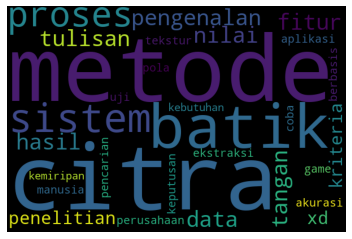

In [32]:
draw_word_cloud(0)